# How to Use ENAS/ProxylessNAS in Ten Minutes

:label:`sec_proxyless`


## What is the Key Idea of ENAS and ProxylessNAS?

Traditional reinforcement learning-based neural architecture search learns an architecture controller
by iteratively sampling the architecture and training the model to get final reward to update the controller. It is extremely expensive process due to training CNN.

![ProxylessNAS](https://raw.githubusercontent.com/zhanghang1989/AutoGluonWebdata/master/docs/tutorial/proxyless.png)

Recent work of ENAS and ProxylessNAS construct an over-parameterized network (supernet) and share the weights across different architecture to speed up the search speed. The reward is calculated every few iterations instead of every training period.

Import MXNet and AutoGluon:

In [1]:
import autogluon as ag
import mxnet as mx
import mxnet.gluon.nn as nn

## How to Construct a SuperNet

Basic NN blocks for CNN.

In [2]:
class Identity(mx.gluon.HybridBlock):
    def hybrid_forward(self, F, x):
        return x
    
class ConvBNReLU(mx.gluon.HybridBlock):
    def __init__(self, in_channels, channels, kernel, stride):
        super().__init__()
        padding = (kernel - 1) // 2
        self.conv = nn.Conv2D(channels, kernel, stride, padding, in_channels=in_channels)
        self.bn = nn.BatchNorm(in_channels=channels)
        self.relu = nn.Activation('relu')
    def hybrid_forward(self, F, x):
        return self.relu(self.bn(self.conv(x)))

### AutoGluon ENAS Unit

In [3]:
from autogluon.contrib.enas import *

@enas_unit()
class ResUnit(mx.gluon.HybridBlock):
    def __init__(self, in_channels, channels, hidden_channels, kernel, stride):
        super().__init__()
        self.conv1 = ConvBNReLU(in_channels, hidden_channels, kernel, stride)
        self.conv2 = ConvBNReLU(hidden_channels, channels, kernel, 1)
        if in_channels == channels and stride == 1:
            self.shortcut = Identity()
        else:
            self.shortcut = nn.Conv2D(channels, 1, stride, in_channels=in_channels)
    def hybrid_forward(self, F, x):
        return self.conv2(self.conv1(x)) + self.shortcut(x)

### AutoGluon Sequntial

Creating a ENAS network using Sequential Block:

In [4]:
mynet = ENAS_Sequential(
    ResUnit(1, 8, hidden_channels=ag.space.Categorical(4, 8), kernel=ag.space.Categorical(3, 5), stride=2),
    ResUnit(8, 8, hidden_channels=8, kernel=ag.space.Categorical(3, 5), stride=2),
    ResUnit(8, 16, hidden_channels=8, kernel=ag.space.Categorical(3, 5), stride=2),
    ResUnit(16, 16, hidden_channels=8, kernel=ag.space.Categorical(3, 5), stride=1, with_zero=True),
    ResUnit(16, 16, hidden_channels=8, kernel=ag.space.Categorical(3, 5), stride=1, with_zero=True),
    nn.GlobalAvgPool2D(),
    nn.Flatten(),
    nn.Activation('relu'),
    nn.Dense(10, in_units=16),
)

mynet.initialize()

#mynet.graph

### Evaluate Network Latency and Define Reward Function

In [5]:
x = mx.nd.random.uniform(shape=(1, 1, 28, 28))
y = mynet.evaluate_latency(x)

Show the latencies:

In [6]:
print('Average latency is {:.2f} ms, latency of the current architecture is {:.2f} ms'.format(mynet.avg_latency, mynet.latency))

Average latency is 2.15 ms, latency of the current architecture is 2.45 ms


We also provide number of params

In [7]:
mynet.nparams

8714

Define the reward function:

In [8]:
reward_fn = lambda metric, net: metric * ((net.avg_latency / net.latency) ** 0.1)

## Start the Training

Construct experiment scheduler, which automatically creates an RL controller based on user-defined search space.

In [9]:
scheduler = ENAS_Scheduler(mynet, train_set='mnist',
                           reward_fn=reward_fn, batch_size=128, num_gpus=1,
                           warmup_epochs=0, epochs=1, controller_lr=3e-3,
                           plot_frequency=10, update_arch_frequency=5)

get_built_in_dataset mnist
get_built_in_dataset mnist


Start the training:

In [10]:
scheduler.run()

The resulting architecture is:

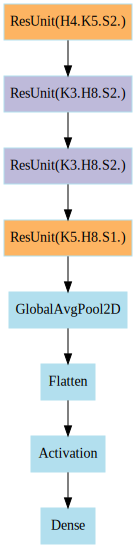

In [11]:
mynet.graph

**Change the reward trade-off:**

In [12]:
reward_fn = lambda metric, net: metric * ((net.avg_latency / net.latency) ** 0.8)
mynet.initialize(force_reinit=True)
scheduler = ENAS_Scheduler(mynet, train_set='mnist',
                           reward_fn=reward_fn, batch_size=128, num_gpus=1,
                           warmup_epochs=0, epochs=1, controller_lr=3e-3,
                           plot_frequency=10, update_arch_frequency=5)
scheduler.run()

get_built_in_dataset mnist
get_built_in_dataset mnist


The resulting architecture is:

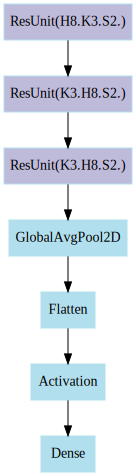

In [13]:
mynet.graph

## Reference

[1] Efficient Neural Architecture Search via Parameter Sharing
    H Pham, MY Guan, B Zoph, QV Le, J Dean
    *International Conference on Machine Learning (ICML)*

[3] ProxylessNAS: Direct Neural Architecture Search on Target Task and Hardware
    Han Cai, Ligeng Zhu, Song Han
    *International Conference on Learning Representations (ICLR)*, 2019.